# Mini projekt 4
Jan Jędrzejewski, Dominik Łopatecki
### Modele generatywne - wygenerować 1000 próbek obrazów na podstawie podanego zbioru zdjęć

In [1]:
import os
import json
import math
import numpy as np 
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder 
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split

<ipython-input-1-098472e37de5>:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


# Dane
Zbiór obrazków znaków 32x32 pikseli

In [ ]:
!unzip trafic_32.zip

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
dataset = ImageFolder(root="./trafic_32", transform=transform)
generator = torch.Generator().manual_seed(42)
train_set, test_set = data.random_split(dataset, [0.2, 0.8], generator=generator)

In [6]:
batch_size=256

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, drop_last=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, drop_last=False, num_workers=2)

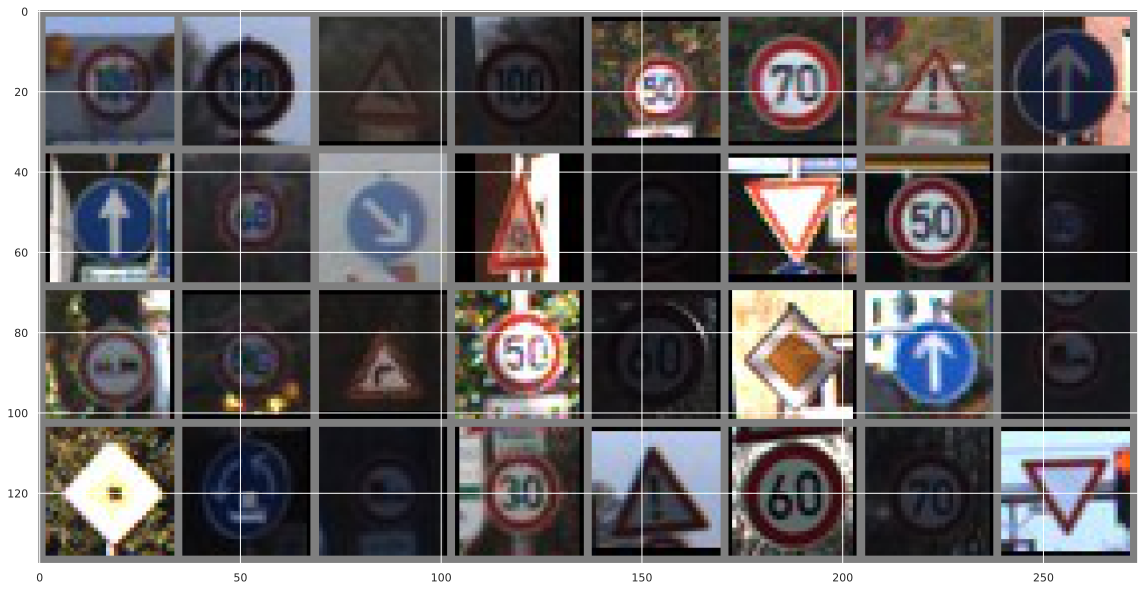

In [7]:
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:32]))

In [8]:
a = next(enumerate(train_loader))
print(a[1][0].shape)
a[1][0].shape[0]

torch.Size([256, 3, 32, 32])


256

# Model sieci

In [65]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.cla = nn.Linear(43, 32*32)   # informacja o klasie z one-hot na obraz 32*32

        # 32x32
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        # 28x28
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=2)
        # 14x14
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5)
        # 10x10
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        # 5x5
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3) 
        # wyjsciowe to 16 kanalow 3x3

        self.fc_1 = nn.Linear(3*3*16, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x, cla):
        x_cla = self.LeakyReLU(self.cla(cla)).view(x.shape[0], 1, 32, 32) # przeksztalcenie informacji o klasie na dodatkowy kanal zgodnie z wymiarami obrazow
        x = torch.cat((x, x_cla), dim=1)  # dodanie nowego kanalu

        x = self.LeakyReLU(self.conv1(x))
        x = self.LeakyReLU(self.conv2(x))
        x = self.LeakyReLU(self.conv3(x))
        x = self.LeakyReLU(self.conv4(x))
        x = self.LeakyReLU(self.conv5(x))

        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)
        
        return mean, log_var

In [66]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(Decoder, self).__init__()

        self.fc_1 = nn.Linear(latent_dim + 43, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 3*3*16)

        # 3x3
        self.conv_t1 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3)
        # 5x5
        self.conv_t2 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=2, stride=2)
        # 10x10
        self.conv_t3 = nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=5)
        # 14x14
        self.conv_t4 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2)
        # 28x28
        self.conv_t5 = nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=5)
        # wyjściowy obrac 32x32
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x, cla):
        x = torch.cat((x, cla), dim=1)

        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))
        h = self.LeakyReLU(self.fc_3(h))
        h = torch.unflatten(h, dim=1, sizes=(16, 3, 3))

        h = self.LeakyReLU(self.conv_t1(h))
        h = self.LeakyReLU(self.conv_t2(h))
        h = self.LeakyReLU(self.conv_t3(h))
        h = self.LeakyReLU(self.conv_t4(h))
        
        h = torch.tanh(self.conv_t5(h))
        return h

In [67]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim)

        
    def reparameterization(self, mean, var):
        z = mean + var * torch.randn_like(var)
        return z
        
                
    def forward(self, x, cla):
        mean, log_var = self.encoder(x, cla)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z, cla)
        return x_hat, mean, log_var

In [68]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

# Uczenie

In [69]:
vae = VAE(latent_dim=256, hidden_dim=512).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

Epoch 0 loss 273502.3645833333, test L1 = 218583.20579268291
Epoch 10 loss 100093.05052083333, test L1 = 97563.76886432926
Epoch 20 loss 91554.18958333334, test L1 = 89857.49279090448
Epoch 30 loss 82050.82838541667, test L1 = 80424.74177464431
Epoch 40 loss 74081.08723958333, test L1 = 73488.84003429877
Epoch 50 loss 70049.56888020833, test L1 = 69789.25882876017
Epoch 60 loss 66315.00559895833, test L1 = 66073.57901422764
Epoch 70 loss 63198.459635416664, test L1 = 63183.89033917683
Epoch 80 loss 60632.336328125, test L1 = 60647.96277947154
Epoch 90 loss 58372.96484375, test L1 = 58992.962493648374


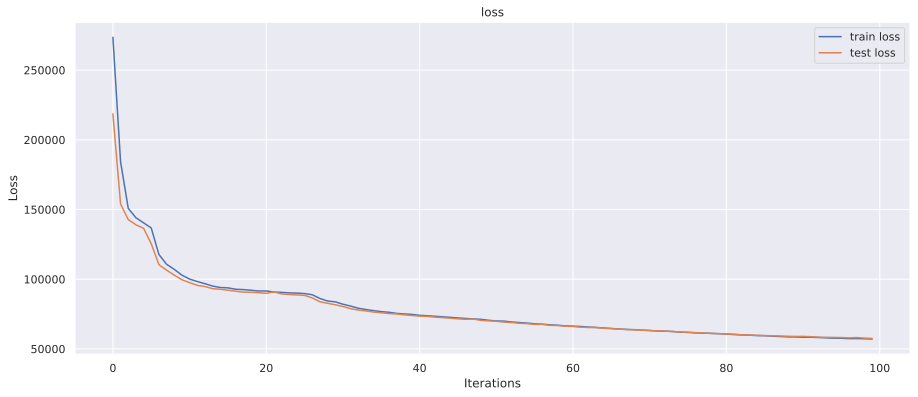

In [70]:
num_epochs = 100
iters, train_loss, test_loss = [], [], []
for n in range(num_epochs):
    iter_train_loss = []
    for x, cla in iter(train_loader):
        x = x.to(device)
        cla = cla.to(device)
        cla = one_hot(cla, 43)
        cla = cla.type(torch.float32)   # cast tensor to float32 to work with x tensor type

        out, means, log_var = vae(x, cla)
        out_cla = out[:, 3]
        out = out[:,0:3]
        loss = vae_loss_function(x, out, means, log_var) 
        iter_train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  
    iter_test_loss = []
    for x, cla in iter(test_loader):
        x  = x.to(device)
        cla = cla.to(device)
        cla = one_hot(cla, 43)
        cla = cla.type(torch.float32)
        out, means, log_var = vae(x, cla)
        out = out[:,0:3]
        loss = vae_loss_function(x, out, means, log_var) 
        iter_test_loss.append(loss.item())
    iters.append(n)
    train_loss.append(np.mean(np.array(iter_train_loss)))
    test_loss.append(np.mean(np.array(iter_test_loss)))
    if n%10 == 0:
        print(f"Epoch {n} loss {np.mean(np.array(iter_train_loss))}, test L1 = {np.mean(iter_test_loss)}")
    scheduler.step()


plt.figure(figsize=(15,6))
plt.plot(iters, train_loss, label="train loss")
plt.plot(iters, test_loss, label="test loss")
plt.title("loss")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()


# Porównanie oryginalnych próbek i rekonstrukcji

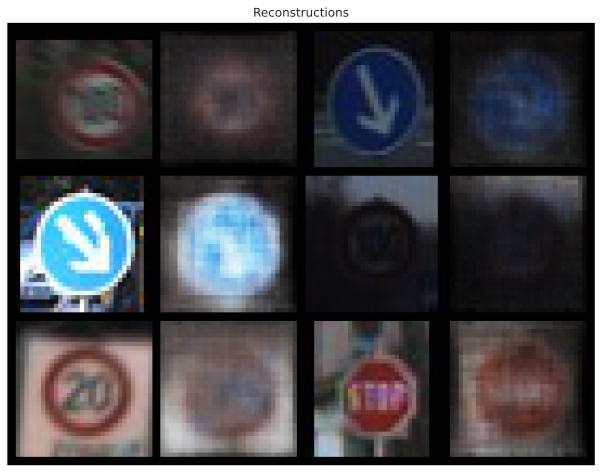

In [135]:
def visualize_reconstructions(model, input_imgs, input_labels, device):
    # Reconstruct images
    model.eval()
    cla = input_labels.to(device)
    cla = one_hot(cla, 43)
    cla = cla.type(torch.float32)
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device), cla)
        reconst_imgs = reconst_imgs[:,0:3]
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs / 2 + 0.5, reconst_imgs / 2 + 0.5], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)

    plt.figure(figsize=(12, 8))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
visualize_reconstructions(model=vae, input_imgs=images[:6], input_labels=labels[:6], device=device)

Rekonstrukcje są podobne do oryginałów, zachowują kolory i kształty. Są jednak mocno rozmazane w środku znaku i ciężko jest odróżnić różne ograniczenia prędkości lub kierunek strzałek

# Przykładowe wygenerowane obrazy

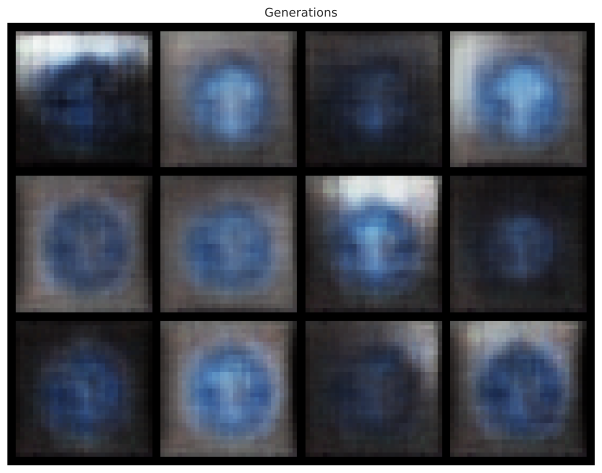

In [137]:
def generate_images(model, n_imgs, device, sign_type):
    # Generate images
    model.eval()
    with torch.no_grad():
        cla = np.zeros(n_imgs)
        cla = cla + sign_type
        cla = torch.tensor(cla, dtype=torch.int64)
        cla = one_hot(cla, 43)
        cla = cla.type(torch.float32)
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device), cla)
        generated_imgs = generated_imgs[:,0:3]
        generated_imgs = generated_imgs / 2 + 0.5
    return generated_imgs

generated_imgs = generate_images(vae, 12 , device,  33).cpu()

grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(12, 8))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()

Podając numer klasy znaków wygenerowaliśmy kilkanaście próbek. Dla powyższego znaku obserwujemy różne oświetlenie i kierunki. Jednak wszyskie są rozmazane w środku znaku.

# Wygenerowanie 1000 próbek

Images in whole dataset: 39209


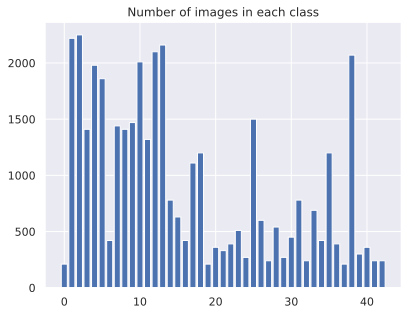

In [111]:
n_of_imgs = []
for n in range(10):
    n_of_imgs.append(len(os.listdir(f"./trafic_32/0000{n}/")))

for n in range(10, 43):
    n_of_imgs.append(len(os.listdir(f"./trafic_32/000{n}/")))

all_imgs = sum(n_of_imgs)
plt.bar(list(range(43)), n_of_imgs)
plt.title("Number of images in each class")
print("Images in whole dataset:", all_imgs)

Generujemy 1000 próbek zgodnie z rozkładem, proporcjonalnie do tego jak występują w zbiorze treningowym

In [138]:
generated_imgs = generate_images(vae, round(1000 * n_of_imgs[0] / all_imgs), device, 0)  # generate samples for class 0

for n in range(1, 43):
    n_imgs = round(1000 * n_of_imgs[n] / all_imgs)      # proportional number of samples for each class
    gen_imgs = generate_images(vae, n_imgs, device,  n)
    generated_imgs = torch.cat((generated_imgs, gen_imgs), 0)

# generate addditional samples up to 1000 (becouse of rounding)
n_imgs = 1000 - len(generated_imgs)     
gen_imgs = generate_images(vae, n_imgs, device,  1)
generated_imgs = torch.cat((generated_imgs, gen_imgs), 0)

print(generated_imgs.shape)
torch.save(generated_imgs.cpu().detach(), "piatek_Jedrzejewski_Lopatecki.pt")

torch.Size([1000, 3, 32, 32])


# Więcej warstw, dłuższe uczenie?

In [139]:
vae2 = VAE(latent_dim=860, hidden_dim=2000).to(device)  # 43x20 = 860
optimizer = optim.Adam(vae2.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

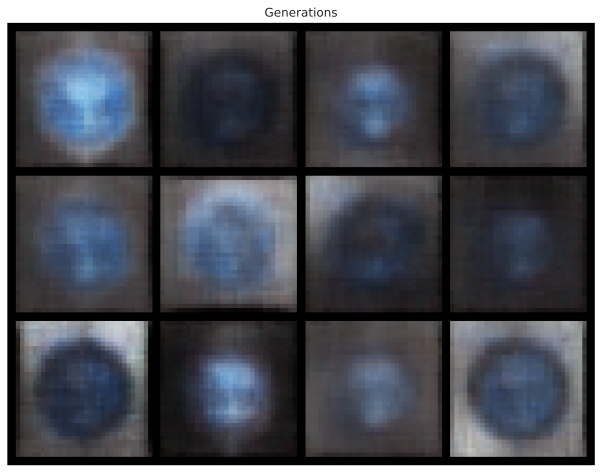

In [145]:
generated_imgs = generate_images(vae2, 12 , device,  33).cpu()

grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
grid = grid.permute(1, 2, 0)

plt.figure(figsize=(12, 8))
plt.title(f"Generations")
plt.imshow(grid)
plt.axis('off')
plt.show()

Model zawierający więcej nauronów w warstwach ukrytych daje podobne rezultaty jak poprzedni model. Dalej znaki są rozmazane, brakuje im szczegółów.